In [2]:
%matplotlib inline


from keras.models import Model
from keras.callbacks import TensorBoard, EarlyStopping
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Activation, Input, TimeDistributed
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU, ELU, PReLU
from keras.optimizers import RMSprop, Adam, Adadelta, Adagrad
import numpy as np
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import binarize

from assignment.helpers import datapreparation as prep

# Note on specifying the initial state of RNNs
# Seems as though you can reset state (probably stateful=True), and then pass an array of initial states that can be used
# in the RNN - so initialize based on composer :D
# https://keras.io/layers/recurrent/

fs5_dirpath = "./assignment/datasets/training/piano_roll_fs5"
fs1_dirpath = "./assignment/datasets/training/piano_roll_fs1"

datasets = prep.load_all_dataset(fs1_dirpath)
dataset_names = prep.load_all_dataset_names(fs1_dirpath)

datasets = [dataset[:, 1:] for dataset in datasets] # Remove the headers

dataset_id_names = dict(zip(np.arange(len(dataset_names)), dataset_names))
longest_song = max(datasets[i].shape[1] for i in range(len(datasets)))
sequence_length = 10 #40
#b_size = 71 # 4047=3*19*71, 0.2 split ==> 3237 = 3*13*83
length = longest_song//sequence_length + 1
num_keys = len(datasets[0])
parts_per_song = int(longest_song/sequence_length)


def transpose_and_label(datasets, num_keys):
    datasets_transposed = np.array([dataset.T for dataset in datasets])
    datasets_transposed_padded_labels = np.array([np.append(dataset[1:, :], np.array([np.ones(num_keys)]), 0) for dataset in datasets_transposed])
    return datasets_transposed, datasets_transposed_padded_labels

def transpose_and_label_stricter(datasets, num_keys):
    xs, ys = [], []
    datasets_transposed = np.array([dataset.T for dataset in datasets])
    for song in datasets_transposed:
        for i in range(0, len(song)//sequence_length):
            xs.append(song[i*sequence_length:(i+1)*sequence_length])
            if i == len(song)//sequence_length - 1: # Add the EOF marker if last seq of song
                ys.append(np.append(song[i*sequence_length+1:(i+1)*sequence_length], np.array([np.ones(num_keys)]), 0))
            else:
                ys.append(song[i*sequence_length+1:(i+1)*sequence_length+1])
    return xs, ys


# Makes several datasets from this first one with differing intervals between to capture the "gaps" between two sequences
def transpose_and_label_more(datasets, num_keys):
    zs = []
    datasets_transposed = np.array([dataset.T for dataset in datasets])
    for song in datasets_transposed:
        for offset in range(0, sequence_length, 2): # 5
            for i in range(0, len(song)//sequence_length):
                x = song[offset+i*sequence_length:offset+(i+1)*sequence_length]
                if i == len(song)//sequence_length - 1: # Add the EOF marker if last seq of song
                    y = np.append(song[offset+i*sequence_length+1:offset+(i+1)*sequence_length], np.array([np.ones(num_keys)]), 0)
                else:
                    y = song[offset+i*sequence_length+1:offset+(i+1)*sequence_length+1]
                zs.append((x,y))
    zs = np.array(zs)
    np.random.shuffle(zs)
    return zs[:, 0], zs[:, 1]

xs, ys = transpose_and_label_more(datasets, num_keys)


xs_concat, ys_concat = np.concatenate(xs, axis=0), np.concatenate(ys, axis=0)

#print(xs_concat.shape) # 68799 = 3*17*19*71

xs_split = np.array([xs_concat[i*sequence_length:(i+1)*sequence_length] for i in range(len(xs_concat)//sequence_length)])
ys_split = np.array([ys_concat[i*sequence_length:(i+1)*sequence_length] for i in range(len(ys_concat)//sequence_length)])

train_xs, train_ys = xs_split[:int(len(xs_split)*0.8)], ys_split[:int(len(ys_split)*0.8)] # Remember to shuffle b4 split xD
test_xs, test_ys = xs_split[int(len(xs_split)*0.8):], ys_split[int(len(ys_split)*0.8):]

inputs = Input(shape=(sequence_length, num_keys))
# Units = units per timestep LSTM block, i.e. output dimensionality (128 here since input and output 128 keys)
lstm1 = LSTM(num_keys,
               activation='relu',
               return_sequences=True,
               stateful=False,
               dropout=0.0, #0.2, #0.25,
               recurrent_dropout=0.0, #0.25,
               kernel_regularizer=None,#l2(0.0001),
               recurrent_regularizer=None, #l2(0.0001),
               bias_regularizer=None,
               activity_regularizer=None,#l2(0.0001),
               )(inputs)
#lstm = LeakyReLU(alpha=.001)(lstm) # Workaround for getting leakyrelu as activation in lstm
normalized1 = BatchNormalization()(lstm1)
dense1 = Dense(num_keys, activation="sigmoid")(normalized1)
lstm2 = LSTM(num_keys,
               activation='relu',
               return_sequences=True,
               stateful=False,
               dropout=0.0, #0.2, #0.25,
               recurrent_dropout=0.0, #0.25,
               kernel_regularizer=None,#l2(0.0001),
               recurrent_regularizer=None, #l2(0.0001),
               bias_regularizer=None,
               activity_regularizer=None,#l2(0.0001),
               )(dense1)
normalized2 = BatchNormalization()(lstm2)
dense2 = Dense(num_keys, activation="sigmoid")(normalized2)
lstm3 = LSTM(num_keys,
               activation='relu',
               return_sequences=True,
               stateful=False,
               dropout=0.0, #0.2, #0.25,
               recurrent_dropout=0.0, #0.25,
               kernel_regularizer=None,#l2(0.0001),
               recurrent_regularizer=None, #l2(0.0001),
               bias_regularizer=None,
               activity_regularizer=None,#l2(0.0001),
               )(dense2)
normalized3 = BatchNormalization()(lstm3)
outputs = TimeDistributed(Dense(num_keys, activation="sigmoid"))(normalized2) # Sigmoid keeps the probabilities independent of each other, while softmax does not!

model = Model(inputs=inputs, outputs=outputs)

rmsprop = RMSprop(lr=0.001)
adagrad =  Adagrad(lr=0.001)
adam = Adam(lr=0.001, amsgrad=True) #Ends up in a point where gradients really small, denominator really small and then loss exploding
adadelta = Adadelta(lr=1.0)

model.save("./models/latest.h5f")
# When LSTM is done can use trainable=False to freeze it while training the other one

Using TensorFlow backend.


In [3]:
keys_not_played = set([i for i in range(num_keys)])
for dataset in datasets:
    for i in range(num_keys):
        if sum(dataset[i,:]) != 0 and i in keys_not_played:
            keys_not_played.remove(i)
print(keys_not_played)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}


In [4]:
# Want to penalize each output node independantly. So we pick a binary loss 
# and model the output of the network as a independent bernoulli distributions per label.

model.compile(loss='binary_crossentropy',
              optimizer=adam, # consider changing this one for others
              metrics=['categorical_accuracy'])
print(model.summary())

tensorboard = TensorBoard(log_dir="./logs/{}".format(time()))
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=3, verbose=0, mode="auto")


model.fit(train_xs, train_ys,
          epochs=250, # Train harder more for more things was too bad train man :(
          batch_size=32,
          shuffle=True,
          validation_data=(test_xs, test_ys),
          callbacks=[tensorboard],
          )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 128)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 10, 128)           16512     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 128)           512       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 128)           16512     
Total para

5420/5420 [==============================] - 4s 764us/step - loss: 0.0561 - categorical_accuracy: 0.1650 - val_loss: 0.1095 - val_categorical_accuracy: 0.1424
Epoch 42/250
5420/5420 [==============================] - 4s 765us/step - loss: 0.0555 - categorical_accuracy: 0.1667 - val_loss: 0.0951 - val_categorical_accuracy: 0.1399
Epoch 43/250
5420/5420 [==============================] - 4s 766us/step - loss: 0.0551 - categorical_accuracy: 0.1672 - val_loss: 0.0954 - val_categorical_accuracy: 0.1453
Epoch 44/250
5420/5420 [==============================] - 4s 767us/step - loss: 0.0548 - categorical_accuracy: 0.1700 - val_loss: 0.0908 - val_categorical_accuracy: 0.1329
Epoch 45/250
5420/5420 [==============================] - 4s 771us/step - loss: 0.0543 - categorical_accuracy: 0.1717 - val_loss: 0.1098 - val_categorical_accuracy: 0.1225
Epoch 46/250
5420/5420 [==============================] - 4s 767us/step - loss: 0.0540 - categorical_accuracy: 0.1724 - val_loss: 0.0924 - val_categorica

Epoch 89/250
5420/5420 [==============================] - 4s 767us/step - loss: 0.0456 - categorical_accuracy: 0.2240 - val_loss: 0.1000 - val_categorical_accuracy: 0.1787
Epoch 90/250
5420/5420 [==============================] - 4s 773us/step - loss: 0.0456 - categorical_accuracy: 0.2242 - val_loss: 0.0817 - val_categorical_accuracy: 0.1861
Epoch 91/250
5420/5420 [==============================] - 4s 771us/step - loss: 0.0446 - categorical_accuracy: 0.2266 - val_loss: 0.0955 - val_categorical_accuracy: 0.1835
Epoch 92/250
5420/5420 [==============================] - 4s 772us/step - loss: 0.0442 - categorical_accuracy: 0.2287 - val_loss: 0.0927 - val_categorical_accuracy: 0.1855
Epoch 93/250
5420/5420 [==============================] - 4s 775us/step - loss: 0.0435 - categorical_accuracy: 0.2313 - val_loss: 0.0940 - val_categorical_accuracy: 0.1813
Epoch 94/250
5420/5420 [==============================] - 4s 776us/step - loss: 0.0433 - categorical_accuracy: 0.2308 - val_loss: 0.0898 - v

5420/5420 [==============================] - 5s 959us/step - loss: 0.0381 - categorical_accuracy: 0.2657 - val_loss: 0.0971 - val_categorical_accuracy: 0.2049
Epoch 137/250
5420/5420 [==============================] - 6s 1ms/step - loss: 0.0383 - categorical_accuracy: 0.2666 - val_loss: 0.0917 - val_categorical_accuracy: 0.2088
Epoch 138/250
5420/5420 [==============================] - 5s 983us/step - loss: 0.0377 - categorical_accuracy: 0.2675 - val_loss: 0.0927 - val_categorical_accuracy: 0.2172
Epoch 139/250
5420/5420 [==============================] - 5s 969us/step - loss: 0.0377 - categorical_accuracy: 0.2657 - val_loss: 0.0981 - val_categorical_accuracy: 0.2228
Epoch 140/250
5420/5420 [==============================] - 6s 1ms/step - loss: 0.0375 - categorical_accuracy: 0.2677 - val_loss: 0.0949 - val_categorical_accuracy: 0.2050
Epoch 141/250
5420/5420 [==============================] - 5s 956us/step - loss: 0.0384 - categorical_accuracy: 0.2681 - val_loss: 0.0893 - val_categoric

5420/5420 [==============================] - 4s 794us/step - loss: 0.0360 - categorical_accuracy: 0.2834 - val_loss: 0.0894 - val_categorical_accuracy: 0.2190
Epoch 184/250
5420/5420 [==============================] - 4s 824us/step - loss: 0.0372 - categorical_accuracy: 0.2775 - val_loss: 0.0815 - val_categorical_accuracy: 0.2366
Epoch 185/250
5420/5420 [==============================] - 4s 800us/step - loss: 0.0349 - categorical_accuracy: 0.2854 - val_loss: 0.0844 - val_categorical_accuracy: 0.2387
Epoch 186/250
5420/5420 [==============================] - 4s 778us/step - loss: 0.0346 - categorical_accuracy: 0.2888 - val_loss: 0.0900 - val_categorical_accuracy: 0.2300
Epoch 187/250
5420/5420 [==============================] - 4s 808us/step - loss: 0.0344 - categorical_accuracy: 0.2875 - val_loss: 0.0855 - val_categorical_accuracy: 0.2308
Epoch 188/250
5420/5420 [==============================] - 5s 1ms/step - loss: 0.0337 - categorical_accuracy: 0.2899 - val_loss: 0.0938 - val_categor

5420/5420 [==============================] - 4s 759us/step - loss: 0.0310 - categorical_accuracy: 0.3064 - val_loss: 0.0932 - val_categorical_accuracy: 0.2327
Epoch 231/250
5420/5420 [==============================] - 4s 763us/step - loss: 0.0308 - categorical_accuracy: 0.3084 - val_loss: 0.0902 - val_categorical_accuracy: 0.2506
Epoch 232/250
5420/5420 [==============================] - 4s 761us/step - loss: 0.0308 - categorical_accuracy: 0.3066 - val_loss: 0.0921 - val_categorical_accuracy: 0.2382
Epoch 233/250
5420/5420 [==============================] - 4s 768us/step - loss: 0.0310 - categorical_accuracy: 0.3072 - val_loss: 0.0935 - val_categorical_accuracy: 0.2430
Epoch 234/250
5420/5420 [==============================] - 4s 766us/step - loss: 0.0314 - categorical_accuracy: 0.3087 - val_loss: 0.0897 - val_categorical_accuracy: 0.2494
Epoch 235/250
5420/5420 [==============================] - 4s 763us/step - loss: 0.0313 - categorical_accuracy: 0.3068 - val_loss: 0.0892 - val_categ

6775/6775 [==============================] - 2s 245us/step
None
None


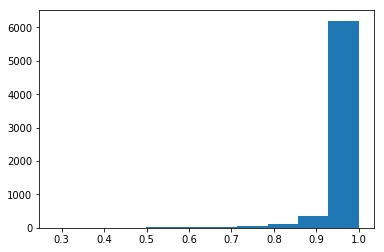

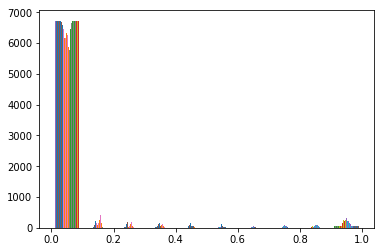

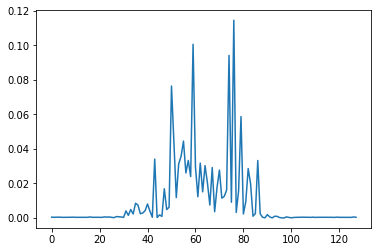

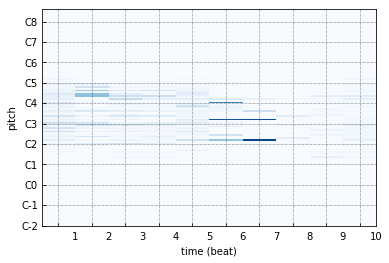

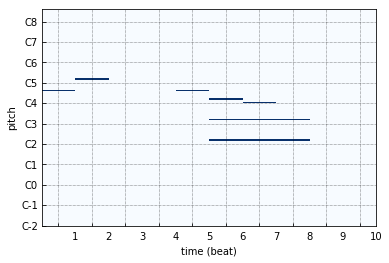

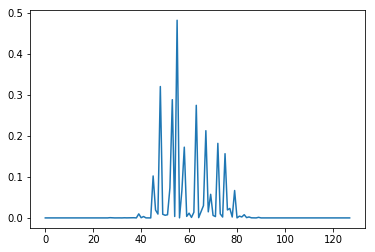

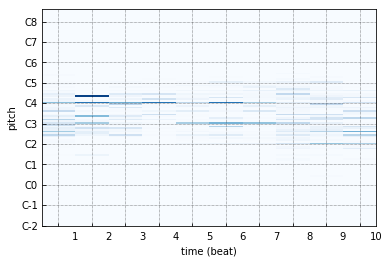

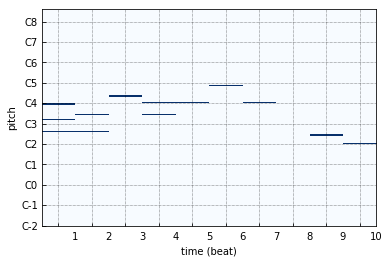

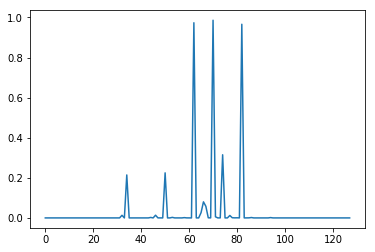

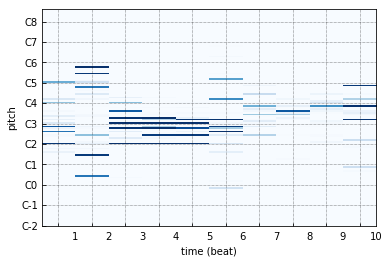

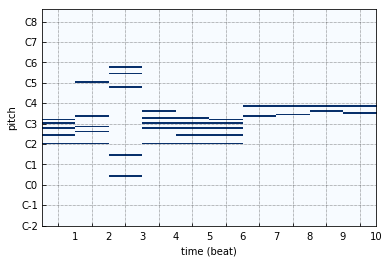

In [5]:
a = model.predict(xs_split, verbose=True)
print(model.layers[1].states[0])
print(model.layers[1].states[0])
maxes = [np.max(c) for c in a]
plt.hist(maxes)
plt.show()
plt.hist(a[:,-1])
plt.show()
b = np.max(a[1][-1])
plt.plot(a[0][-1])
plt.show()
prep.visualize_piano_roll(a[0].T, fs=1)
prep.visualize_piano_roll(xs_split[0].T, fs=1)
plt.plot(a[100][-1])
plt.show()
prep.visualize_piano_roll(a[100].T, fs=1)
prep.visualize_piano_roll(xs_split[100].T, fs=1)
plt.plot(a[200][-1])
plt.show()
prep.visualize_piano_roll(a[200].T, fs=1)
prep.visualize_piano_roll(xs_split[200].T, fs=1)

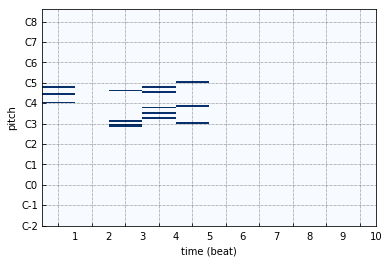

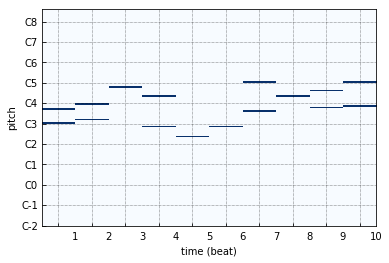

In [11]:
def make_song_from_predict(model, initial_data, limit):
    song = []
    keep_producing = True
    prev_data = initial_data
    while keep_producing and len(song) < limit:
        #print("input", prev_data)
        predictions = model.predict(np.array([prev_data]))[0]
        #print("output", predictions[-1])
        #plt.plot(predictions[-1])
        #plt.show()
        labels = np.zeros(predictions.shape)
        labels[predictions>0.5] = 1 # Weak activations, want to scale to 0/1
        last_output = labels[-1]
        #print("output scaled:", last_output)
        keep_producing = np.sum(last_output) != len(last_output)
        song.append(last_output)
        prev_data = np.append(prev_data[1:], [last_output], 0)
    return np.array(song)

initial_step = 1250
song = make_song_from_predict(model, test_xs[initial_step], sequence_length)
prep.visualize_piano_roll(song.T, fs=1)
prep.visualize_piano_roll(test_xs[initial_step].T, fs=1)
prep.embed_play_v1(song.T, fs=1)


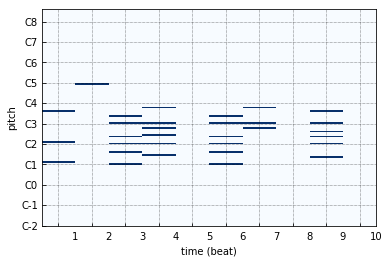

In [7]:
prep.visualize_piano_roll(test_xs[initial_step+1].T, fs=1)
prep.embed_play_v1(test_xs[initial_step+1].T, fs=1)